### separate out a validation dataset

In [1]:
from pandas import read_csv
series = read_csv('champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 93, Validation 12


### evaluate persistence model on time series

In [3]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# 	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 3186.501


### summary statistics of time series

In [ ]:
from pandas import read_csv
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())

### line plot of time series

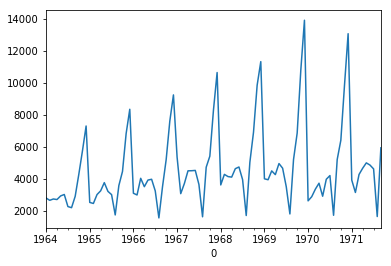

In [4]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

### multiple line plots of time series

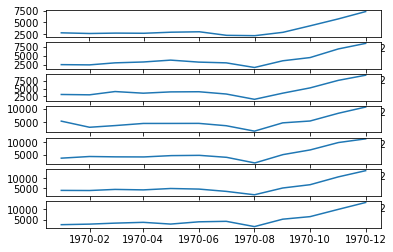

In [6]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

### density plots of time series

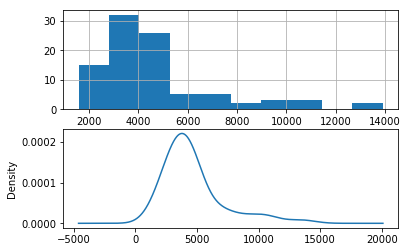

In [8]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

### boxplots of time series

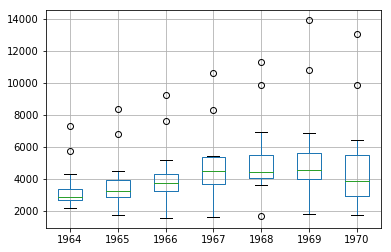

In [9]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

### create and summarize stationary version of time series

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


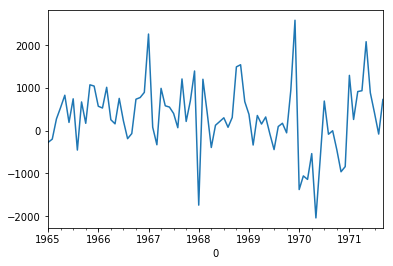

In [13]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

### ACF and PACF plots of time series

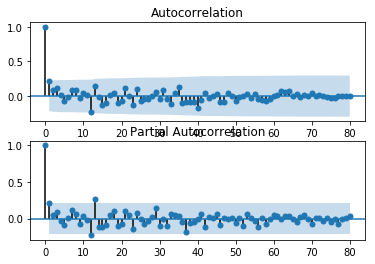

In [14]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

### evaluate manually configured ARIMA model

In [12]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# 	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 956.945


### grid search ARIMA parameters for time series

In [15]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.784
ARIMA(0, 0, 5) RMSE=986.832
ARIMA(0, 0, 6) RMSE=1087.028
ARIMA(0, 1, 1) RMSE=958.300
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.945
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.956
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.660
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.939
ARIMA(3, 2, 0) RMSE=1244.846
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.259
ARIMA(4, 2, 0) RMSE=1227.556
ARIMA(4, 2, 1) RMSE=1055.488
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.403
ARIMA(5, 1, 2) RMSE=1003.137
ARIMA(5, 2, 1) RMSE=1053.718
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 1, 0) RMSE=1018.211
ARIMA(6, 1, 1) RMSE=1023.761
Best ARIMA(0, 0, 1) RMSE=939.

### summarize ARIMA forecast residuals

                 0
count    47.000000
mean    165.904730
std     934.696204
min   -2164.247449
25%    -289.651596
50%     191.759548
75%     732.992187
max    2367.304815


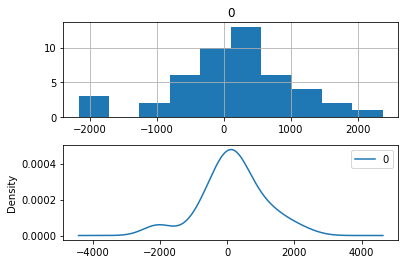

In [16]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

### plots of residual errors of bias corrected forecasts

RMSE: 924.699
                 0
count    47.000000
mean      0.000002
std     934.696204
min   -2330.152177
25%    -455.556324
50%      25.854820
75%     567.087459
max    2201.400087


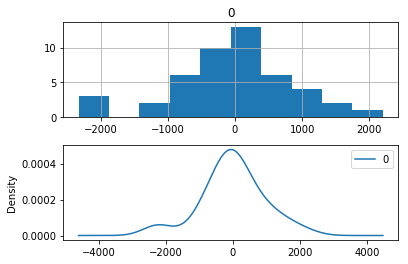

In [17]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904728
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

### ACF and PACF plots of residual errors of bias corrected forecasts

                 0
count    47.000000
mean    165.904730
std     934.696204
min   -2164.247449
25%    -289.651596
50%     191.759548
75%     732.992187
max    2367.304815


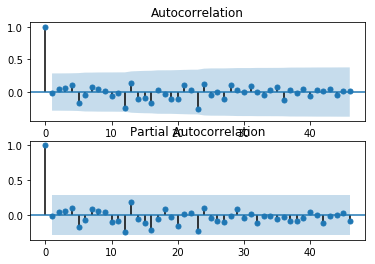

In [18]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

### save finalized model

In [19]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

### load finalized model and make a prediction

In [20]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6794.773


### load and evaluate the finalized model on the validation dataset

>Predicted=6794.773, Expected=6981
>Predicted=10101.763, Expected=9851
>Predicted=13219.067, Expected=12670
>Predicted=3996.535, Expected=4348
>Predicted=3465.934, Expected=3564
>Predicted=4522.683, Expected=4577
>Predicted=4901.336, Expected=4788
>Predicted=5190.094, Expected=4618
>Predicted=4930.190, Expected=5312
>Predicted=4944.785, Expected=4298
>Predicted=1699.409, Expected=1413
>Predicted=6085.324, Expected=5877
RMSE: 361.110


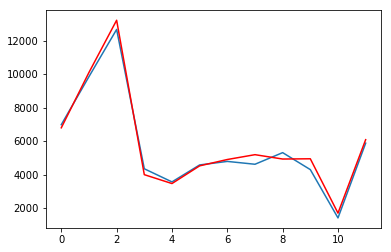

In [21]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()